In [137]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import KMeansSMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import warnings
import numpy as np
warnings.filterwarnings("ignore")

In [138]:
class_train = pd.read_csv("train_3.csv")
class_test = pd.read_csv("test_3.csv")
regression_train = pd.read_csv("train_4.csv")
regression_test = pd.read_csv("test_4.csv")
ids_class = class_test['id']
ids_reg = regression_test['id']

# Предварительная обработка

### Классификация

In [139]:
 # Определение типов признаков
class_cat = ["Sex", "HasPartner", "HasChild", "HasPhoneService", 
             "HasMultiplePhoneNumbers", "HasInternetService", 
             "HasOnlineSecurityService", "HasOnlineBackup", 
             "HasDeviceProtection", "HasTechSupportAccess", 
             "HasOnlineTV", "HasMovieSubscription", 
             "HasContractPhone", "IsBillingPaperless", 
             "PaymentMethod", "IsSeniorCitizen"]

class_num = ["ClientPeriod", "MonthlySpending", "TotalSpent"]

class_all = class_cat + class_num

# Предварительная обработка числовых столбцов
for column in class_num:
    # Заменяем пробелы на NaN и преобразуем в числа
    class_train[column] = pd.to_numeric(class_train[column].replace(' ', np.nan), errors='coerce')
    class_test[column] = pd.to_numeric(class_test[column].replace(' ', np.nan), errors='coerce')
    
    # Заполняем пропущенные значения (например, средним)
    mean_val = class_train[column].mean()
    class_train[column].fillna(mean_val, inplace=True)
    class_test[column].fillna(mean_val, inplace=True)

# Удаление столбца id (если есть)
class_train.drop("id", axis=1, inplace=True, errors='ignore')
class_test.drop("id", axis=1, inplace=True, errors='ignore')

# Кодирование категориальных признаков
le = LabelEncoder()
for column in class_cat:
    class_train[column] = le.fit_transform(class_train[column].astype(str))
    class_test[column] = le.transform(class_test[column].astype(str))
    class_train[column] = class_train[column].astype("category")
    class_test[column] = class_test[column].astype("category")

# Масштабирование числовых признаков
scaler = MinMaxScaler()
class_train[class_num] = scaler.fit_transform(class_train[class_num])
class_test[class_num] = scaler.transform(class_test[class_num])


class_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   ClientPeriod              3169 non-null   float64 
 1   MonthlySpending           3169 non-null   float64 
 2   TotalSpent                3169 non-null   float64 
 3   Sex                       3169 non-null   category
 4   IsSeniorCitizen           3169 non-null   category
 5   HasPartner                3169 non-null   category
 6   HasChild                  3169 non-null   category
 7   HasPhoneService           3169 non-null   category
 8   HasMultiplePhoneNumbers   3169 non-null   category
 9   HasInternetService        3169 non-null   category
 10  HasOnlineSecurityService  3169 non-null   category
 11  HasOnlineBackup           3169 non-null   category
 12  HasDeviceProtection       3169 non-null   category
 13  HasTechSupportAccess      3169 non-null   catego

### Регрессия

In [140]:
regression_result = 'Цена'
regression_train.drop("id", axis=1, inplace=True)
regression_test.drop("id", axis=1, inplace=True)
regression_train.drop("Без.ремонта", axis=1, inplace=True)
regression_train.drop("Совмещенный.санузел", axis=1, inplace=True)
regression_train.drop("Смешанные.стены", axis=1, inplace=True)
regression_train.drop("Иные.перекрытия", axis=1, inplace=True)
# Разделение на числовые и категориальные
regression_num = []
regression_cat = []
for name in regression_train.columns:
    if regression_train[name].nunique() > 5:
        regression_num.append(name)
    else:
        regression_cat.append(name)
regression_num.remove(regression_result)
regression_all = regression_num + regression_cat
# Нормализация числовых признаков
scaler = MinMaxScaler()
regression_train[regression_num] = scaler.fit_transform(regression_train[regression_num])
regression_test[regression_num] = scaler.fit_transform(regression_test[regression_num])
regression_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Количество.комнат          808 non-null    int64  
 1   Студия                     808 non-null    int64  
 2   Общая.площадь              808 non-null    float64
 3   Этаж                       808 non-null    float64
 4   Этажей.в.доме              808 non-null    float64
 5   Парковка                   808 non-null    int64  
 6   Дизайнерский               808 non-null    int64  
 7   Евроремонт                 808 non-null    int64  
 8   Косметический              808 non-null    int64  
 9   Балкон                     808 non-null    int64  
 10  Лоджия                     808 non-null    int64  
 11  Раздельный.санузел         808 non-null    int64  
 12  Лифт                       808 non-null    int64  
 13  Грузовой.лифт              808 non-null    int64  

### Балансировка для классификации

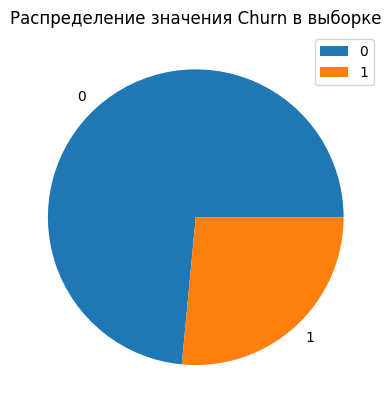

In [141]:
plt.pie(class_train["Churn"].value_counts(), labels=(0, 1))
plt.title("Распределение значения Churn в выборке")
plt.legend((0, 1))
plt.show()

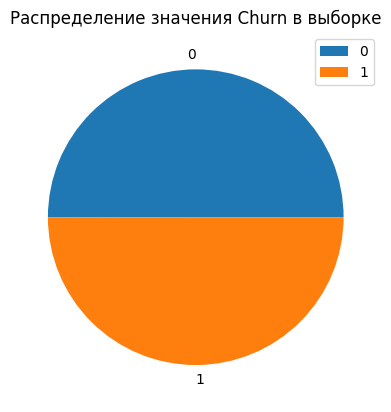

In [142]:
x = class_train[class_num + class_cat]
y = class_train["Churn"]
x, y = KMeansSMOTE(cluster_balance_threshold=0.3).fit_resample(x, y)
plt.pie(y.value_counts(), labels=(0, 1))
plt.title("Распределение значения Churn в выборке")
plt.legend((0, 1))
plt.show()

Теперь данные сбалансированы

#### Разделение данных на обучающую и тестовую выборки

In [143]:

x_train_class, x_test_class, y_train_class, y_test_class = train_test_split(x, y, test_size=0.3, random_state=7)
x = regression_train[regression_all]
y = regression_train[regression_result]
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x, y, test_size=0.3, random_state=7)

In [144]:
#  Сравнивает производительность модели при разных гиперпараметрах.
def compare_parameters(parameters, test_scores, train_scores, is_regression=False):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))  
    fig.subplots_adjust(hspace=0.4)
    id = 0
    for key in test_scores.keys():
        if key != "criterion":
            plot_accuracy_graph(parameters[key], key, axs[id], train_scores[key], test_scores[key],
                                 regression=is_regression)
        else:
            plot_criteria(parameters[key], axs[id], train_scores[key], test_scores[key], regression=is_regression)
        id += 1

# Создает и обучает модель с лучшими параметрами
def create_best_model(params, is_regression=False):
    model_class = DecisionTreeRegressor if is_regression else DecisionTreeClassifier
    model = model_class(**params)
    model.fit(x_train_reg if is_regression else x_train_class,
              y_train_reg if is_regression else y_train_class)
    score = model.score(x_test_reg if is_regression else x_test_class,
                        y_test_reg if is_regression else y_test_class)
    print(f"Model: {model}\nScore: {round(score, 3)}")
    return model, score

# Запускает поиск по сетке (GridSearchCV) для подбора гиперпараметров
def build_grid(params, x_train, y_train, x_test, y_test, is_regression):
    model_class = DecisionTreeRegressor if is_regression else DecisionTreeClassifier
    scoring = 'neg_mean_squared_error' if is_regression else 'roc_auc'
    grid = GridSearchCV(model_class(), params, scoring=scoring)
    grid.fit(x_train, y_train)
    score = grid.best_score_ if not is_regression else r2_score(y_test, grid.predict(x_test))
    print(f"The best model: {grid.best_estimator_}\nAccuracy: {round(score, 3)}")
    return grid.cv_results_["mean_test_score"], grid.best_params_

# Тестирует влияние одного параметра на точность
def test_parameters(parameters, train_acc, test_acc, cross_val_acc,  x_train, y_train, x_test, y_test, is_regression=False):
    parameter_name = next(iter(parameters.keys()))
    train_acc[parameter_name] = []
    test_acc[parameter_name] = []
    for parameter in parameters[parameter_name]:
        value = {parameter_name: parameter}
        if is_regression:
            clf = DecisionTreeRegressor(**value)
        else:
            clf = DecisionTreeClassifier(**value)
        clf.fit(x_train, y_train)
        if not is_regression: 
            y_pred_train = clf.predict(x_train)
            y_pred_test = clf.predict(x_test) 
            train_acc[parameter_name].append(accuracy_score(y_train, y_pred_train))
            test_acc[parameter_name].append(accuracy_score(y_test, y_pred_test))
        else:
            train_acc[parameter_name].append(clf.score(x_train, y_train))
            test_acc[parameter_name].append(clf.score(x_test, y_test))
    cross_val, best_param = build_grid(parameters, x_train, y_train, x_test, y_test, is_regression)
    cross_val_acc[parameter_name] = cross_val
    return best_param[parameter_name]

# Визуализирует точность для разных критериев (gini, entropy)
def plot_criteria(parameters, ax, train_acc, test_acc, regression=False):
    ax.bar(parameters, train_acc, label="train")
    ax.bar(parameters, test_acc, label="test")
    ax.legend()
    ax.set_xlabel("criteria", labelpad=15)
    ax.set_title(f"Accuracy vs criteria" if not regression else f"R^2 vs criteria")
    ax.set_ylabel("Accuracy" if not regression else "R^2", labelpad=15)

# Строит график зависимости точности от параметра.
def plot_accuracy_graph(parameters, parameter_name, ax, train_acc, test_acc, regression=False):
    ax.plot(parameters, train_acc, label="Train")
    ax.plot(parameters, test_acc, label="Test")
    ax.set_xlabel(parameter_name, labelpad=15)
    ax.set_title(f"Accuracy vs {parameter_name}" if not regression else f"R^2 vs {parameter_name}")
    ax.set_ylabel("Accuracy" if not regression else "R^2", labelpad=15)
    ax.legend()


## Классификация

In [145]:
train_acc = {}  # Для хранения accuracy на тренировочных данных
test_acc = {}   # Для хранения accuracy на тестовых данных
cross_val_acc = {}  # Для хранения результатов кросс-валидации

In [146]:
params = {
    "criterion": ["gini", "entropy", "log_loss"],  # Критерии разделения
    "max_leaf_nodes": range(2, 40, 3),  # Макс. число листьев (от 2 до 40 с шагом 3)
    "max_depth": range(2, 15)  # Макс. глубина дерева (от 2 до 15)
}
best_parameters_сlass = dict()

In [147]:
# Подбор criterion
best_parameters_сlass["criterion"] = test_parameters(
    {"criterion": params["criterion"]}, 
    train_acc, test_acc, cross_val_acc,
    x_train_class, y_train_class, x_test_class, y_test_class
)

# Подбор max_leaf_nodes
best_parameters_сlass["max_leaf_nodes"] = test_parameters(
    {"max_leaf_nodes": params["max_leaf_nodes"]}, 
    train_acc, test_acc, cross_val_acc,
    x_train_class, y_train_class, x_test_class, y_test_class
)

# Подбор max_depth
best_parameters_сlass["max_depth"] = test_parameters(
    {"max_depth": params["max_depth"]}, 
    train_acc, test_acc, cross_val_acc,
    x_train_class, y_train_class, x_test_class, y_test_class
)

The best model: DecisionTreeClassifier(criterion='entropy')
Accuracy: 0.803
The best model: DecisionTreeClassifier(max_leaf_nodes=32)
Accuracy: 0.898
The best model: DecisionTreeClassifier(max_depth=7)
Accuracy: 0.891


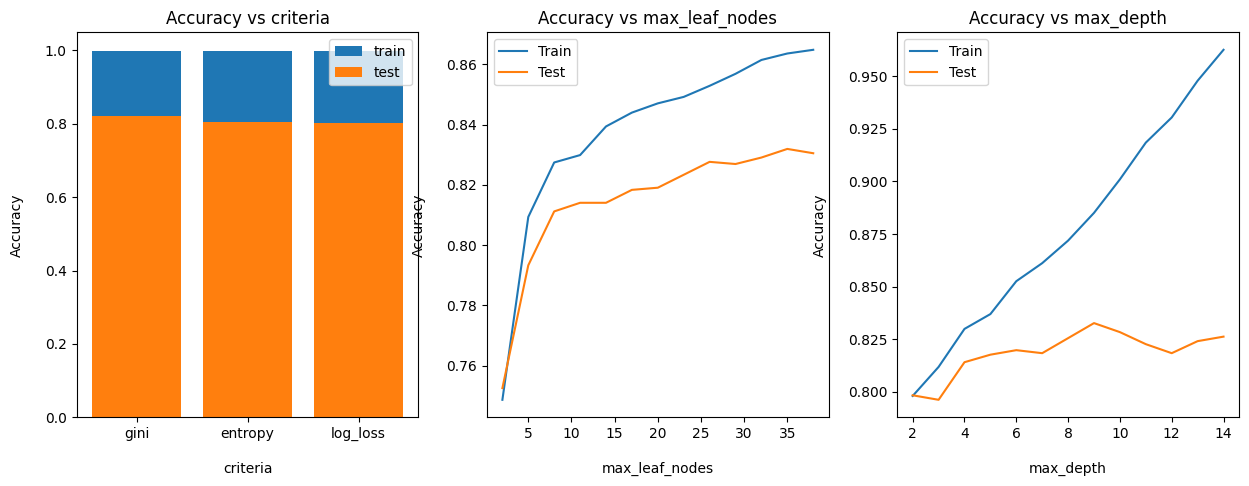

In [148]:
compare_parameters(params, test_acc, train_acc)  

## Cоздание, обучение и применение модели классификации

Model: DecisionTreeClassifier(criterion='entropy', max_depth=7, max_leaf_nodes=32)
Score: 0.81
Файл submission_class.csv сохранен.


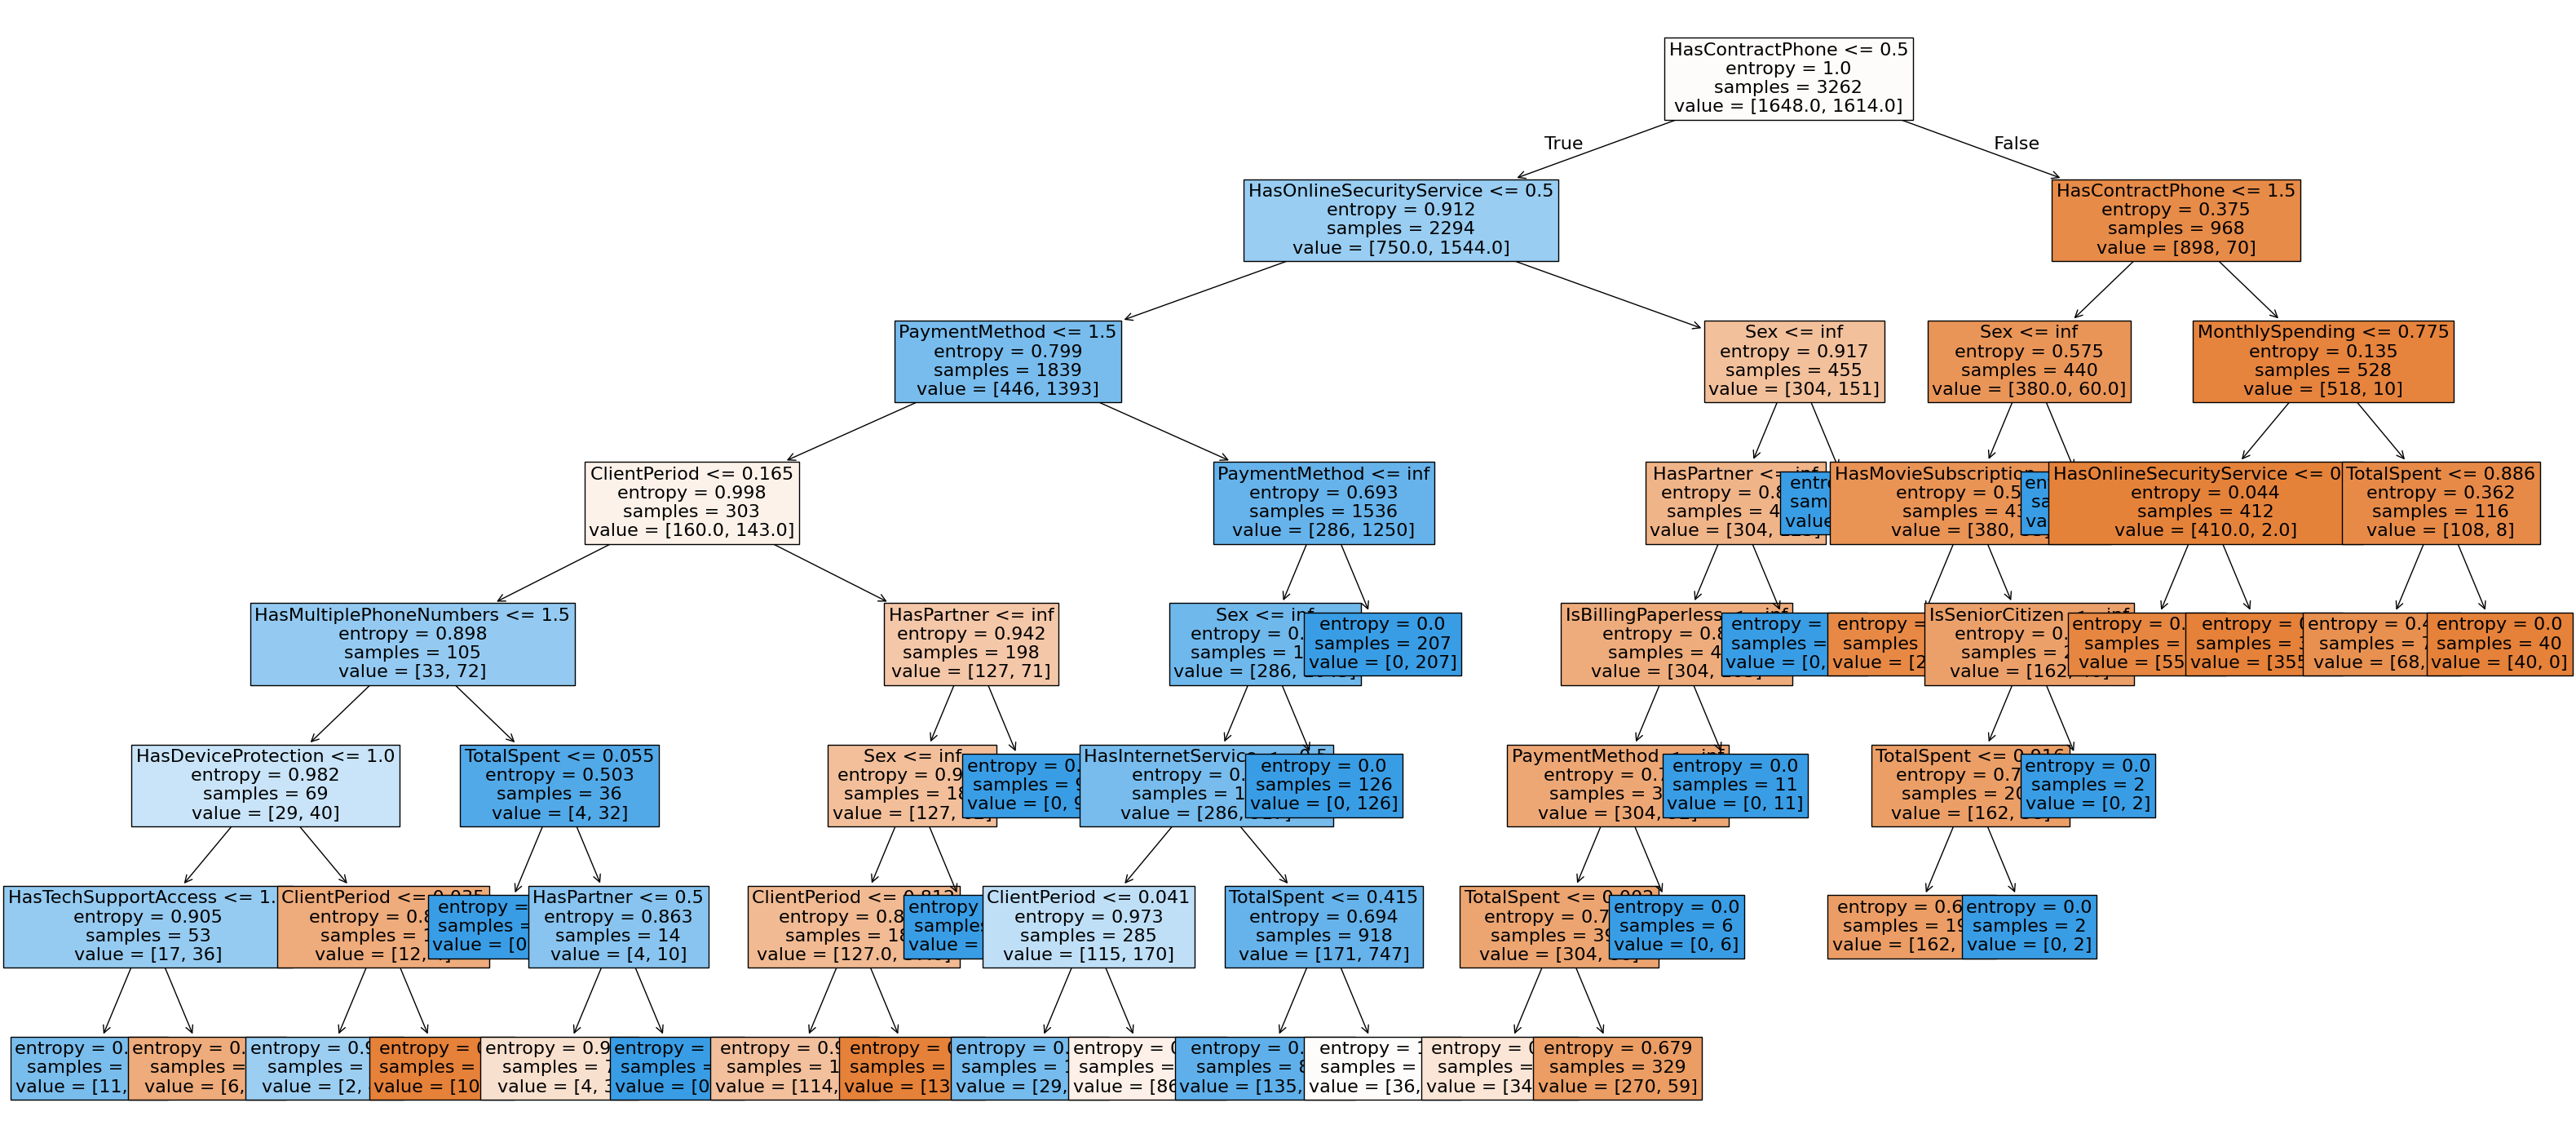

In [149]:
model, class_score = create_best_model(best_parameters_сlass)
class_test = class_test[class_num + class_cat]
y_pred = model.predict(class_test)
submission_class = pd.DataFrame({'id': ids_class, 'Churn': y_pred})

submission_class.to_csv('submission_class.csv', index=False)
print("Файл submission_class.csv сохранен.")

plt.figure(figsize=(40, 18))  # Ширина x Высота в дюймах
tree.plot_tree(model, 
               filled=True, 
               feature_names=list(x_test_class.columns),
               fontsize=16)  # Размер шрифта
plt.show()

## Регрессия

In [150]:
train_acc = {}
test_acc = {}
cross_val_acc = {}
best_parameters_reg = dict()

params = {
    "criterion": ["poisson", "friedman_mse", "absolute_error", "squared_error"],
    "max_leaf_nodes": range(2, 40, 3),
    "max_depth": range(2, 15)
}   

In [151]:

best_parameters_reg["criterion"] = test_parameters({"criterion": params["criterion"]}, train_acc, test_acc, cross_val_acc, 
                                               x_train_reg, y_train_reg, x_test_reg, y_test_reg, is_regression=True)
best_parameters_reg["max_leaf_nodes"] = test_parameters({"max_leaf_nodes": params["max_leaf_nodes"]}, train_acc, test_acc, cross_val_acc, 
                                                    x_train_reg, y_train_reg, x_test_reg, y_test_reg, is_regression=True)
best_parameters_reg["max_depth"] = test_parameters({"max_depth": params["max_depth"]}, train_acc, test_acc, cross_val_acc, 
                                               x_train_reg, y_train_reg, x_test_reg, y_test_reg, is_regression=True)

The best model: DecisionTreeRegressor(criterion='friedman_mse')
Accuracy: 0.808
The best model: DecisionTreeRegressor(max_leaf_nodes=17)
Accuracy: 0.845
The best model: DecisionTreeRegressor(max_depth=4)
Accuracy: 0.844


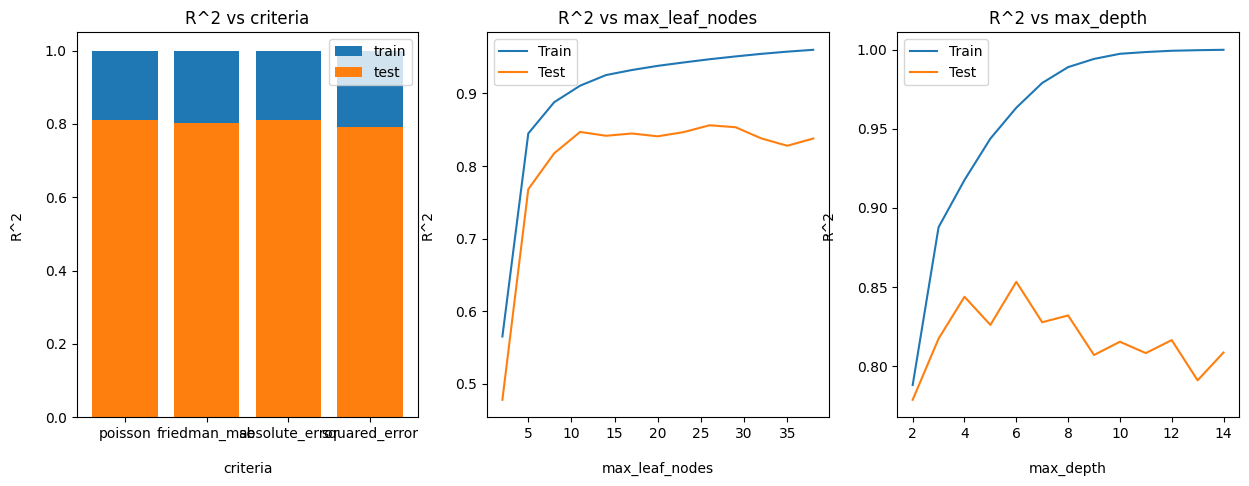

In [152]:
compare_parameters(params, test_acc, train_acc, is_regression=True) 

In [153]:
print(regression_test)

     Количество.комнат  Студия  Общая.площадь      Этаж  Этажей.в.доме  \
0                    1       0       0.204545  0.125000           0.56   
1                    1       0       0.172727  0.000000           0.00   
2                    1       0       0.194697  0.041667           0.60   
3                    4       0       0.541667  0.375000           0.32   
4                    1       0       0.227273  0.375000           0.32   
..                 ...     ...            ...       ...            ...   
778                  2       0       0.272727  0.166667           0.12   
779                  4       0       0.545455  0.375000           0.32   
780                  1       0       0.181818  0.291667           0.32   
781                  2       0       0.310606  0.083333           0.12   
782                  2       0       0.289394  0.000000           0.08   

     Парковка  Без.ремонта  Дизайнерский  Евроремонт  Косметический  ...  \
0           0            0         

In [154]:
print(regression_train)

     Количество.комнат  Студия  Общая.площадь      Этаж  Этажей.в.доме  \
0                    2       0       0.327273  0.086957       0.125000   
1                    2       0       0.314545  0.173913       0.125000   
2                    2       0       0.390909  0.000000       0.291667   
3                    2       0       0.490909  0.130435       0.125000   
4                    1       0       0.211818  0.000000       0.333333   
..                 ...     ...            ...       ...            ...   
803                  1       0       0.254545  0.217391       0.291667   
804                  3       0       0.327273  0.130435       0.083333   
805                  1       0       0.218182  0.347826       0.583333   
806                  2       0       0.327273  0.000000       0.125000   
807                  1       0       0.185455  0.130435       0.125000   

     Парковка  Дизайнерский  Евроремонт  Косметический  Балкон  ...  \
0           0             0           0 

Model: DecisionTreeRegressor(criterion='friedman_mse', max_depth=4, max_leaf_nodes=17)
Score: 0.844
Файл submission_reg.csv сохранен.


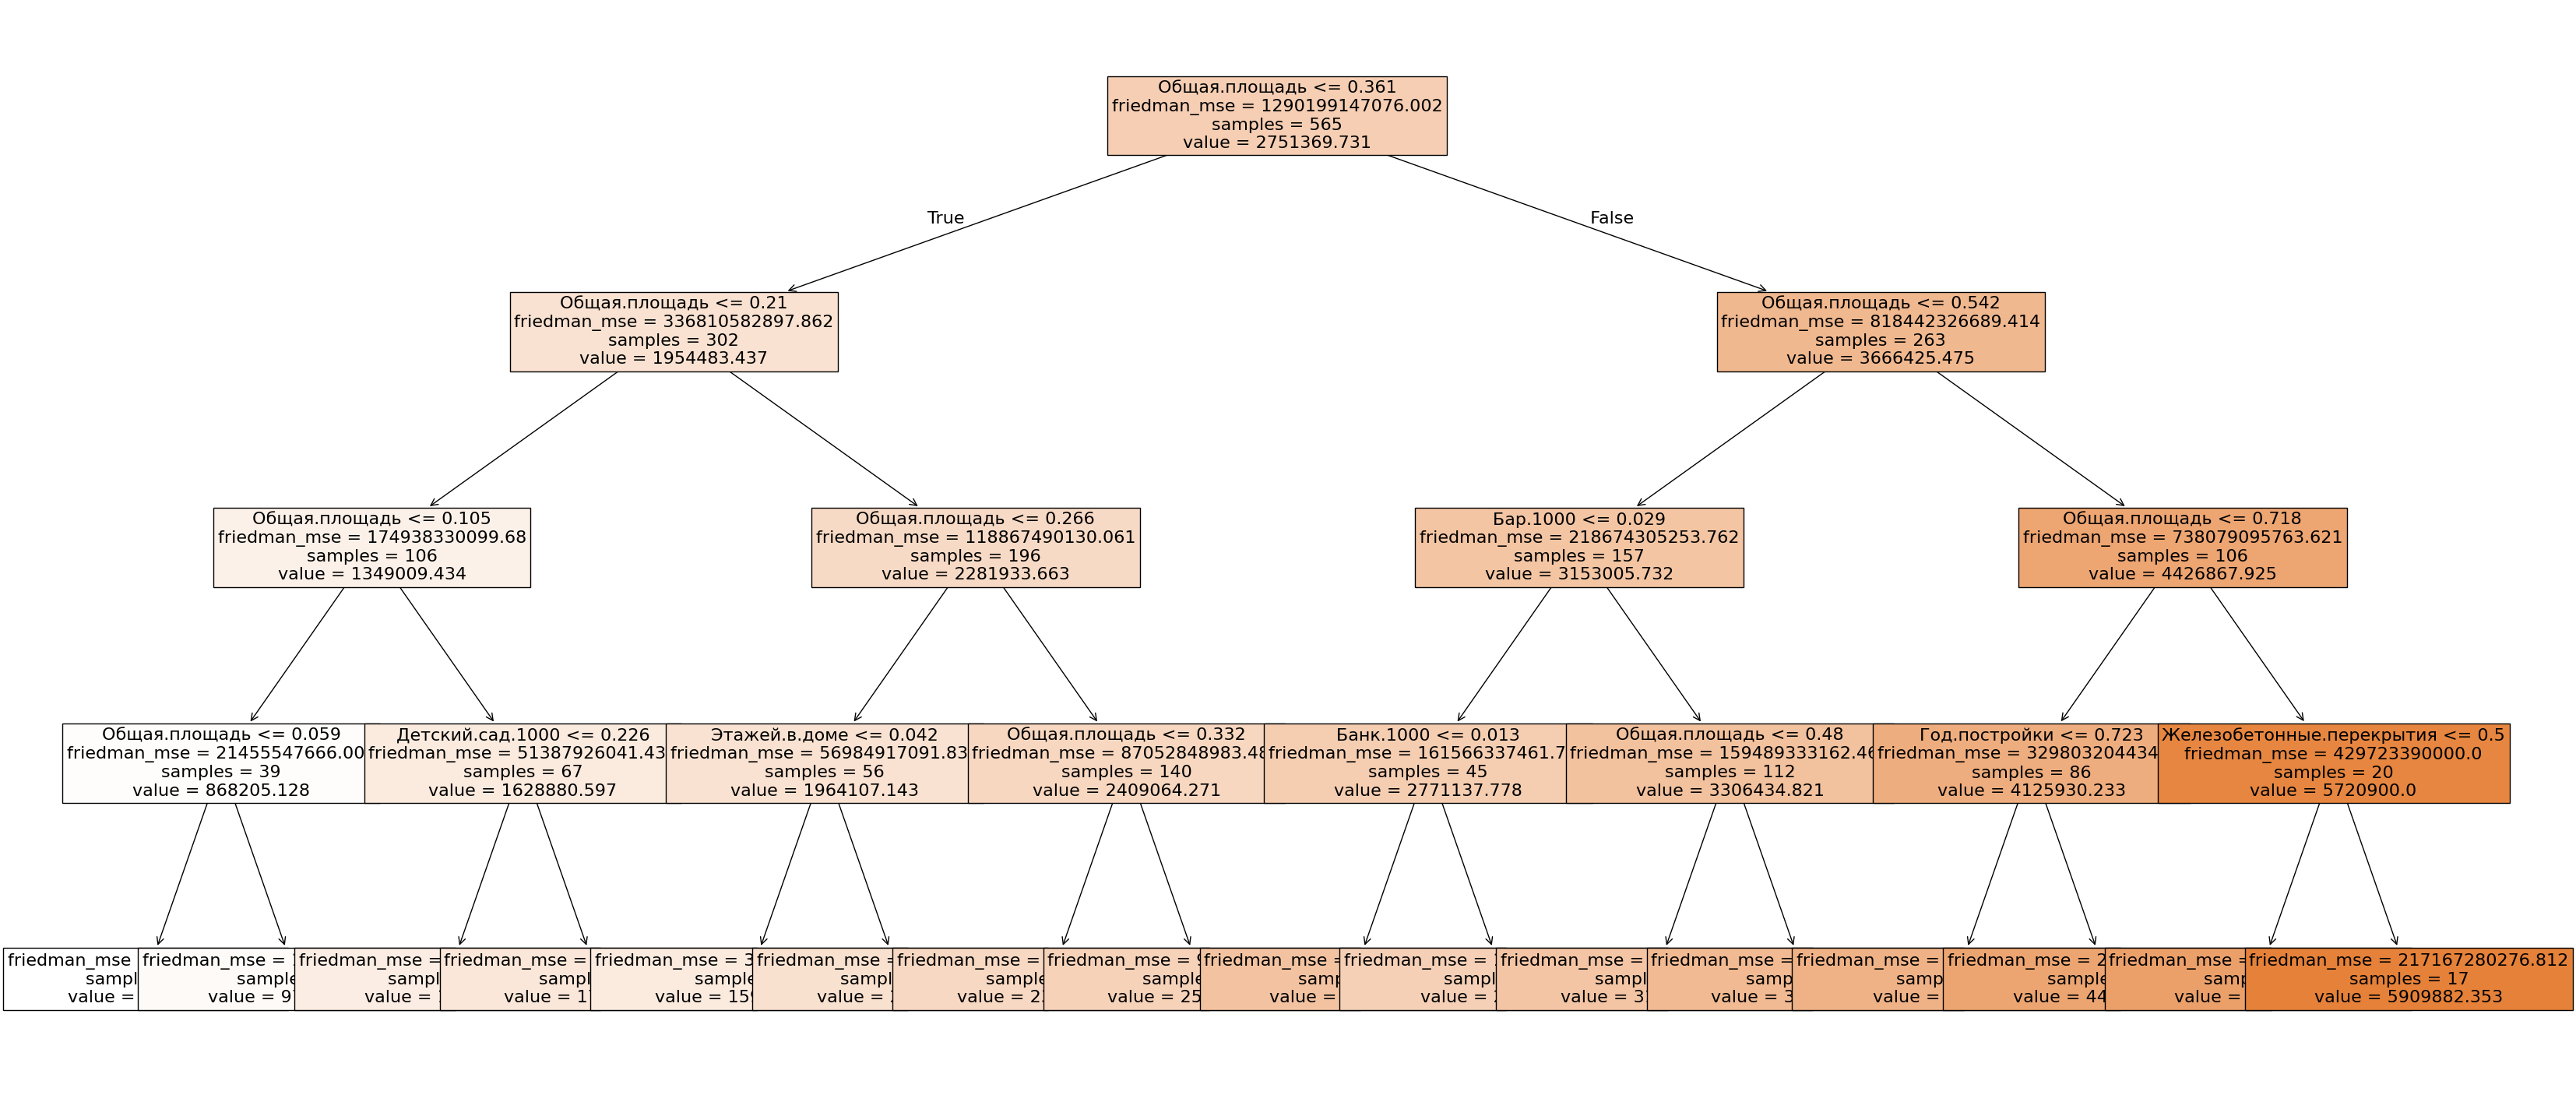

In [155]:

model, regr_score = create_best_model(best_parameters_reg, is_regression=True)
regression_test = regression_test[regression_all]
y_pred = model.predict(regression_test)
submission_reg = pd.DataFrame({'id': ids_reg, 'Цена': y_pred})

submission_reg.to_csv('submission_reg.csv', index=False)
print("Файл submission_reg.csv сохранен.")


plt.figure(figsize=(40, 18))  # Ширина x Высота в дюймах

tree.plot_tree(model, filled=True, feature_names=list(x_test_reg.columns), fontsize=16)

plt.show()

## Обрезка деревьев

### Классификация

In [156]:


dtc = DecisionTreeClassifier(criterion="entropy", max_depth=5)
params = {"ccp_alpha": [0, 0.001, 0.005, 0.01, 0.02]}  # Вручную задать разумные значения
grid = GridSearchCV(dtc, params, cv=5, scoring="accuracy")
grid.fit(x_train_class, y_train_class)

best_cpp = grid.best_params_["ccp_alpha"]
best_model = grid.best_estimator_
print(f"Лучшее ccp_alpha: {best_cpp}, Accuracy: {grid.best_score_:.3f}")



Лучшее ccp_alpha: 0, Accuracy: 0.823


Model: DecisionTreeClassifier(ccp_alpha=0, criterion='entropy', max_depth=7,
                       max_leaf_nodes=32)
Score: 0.806


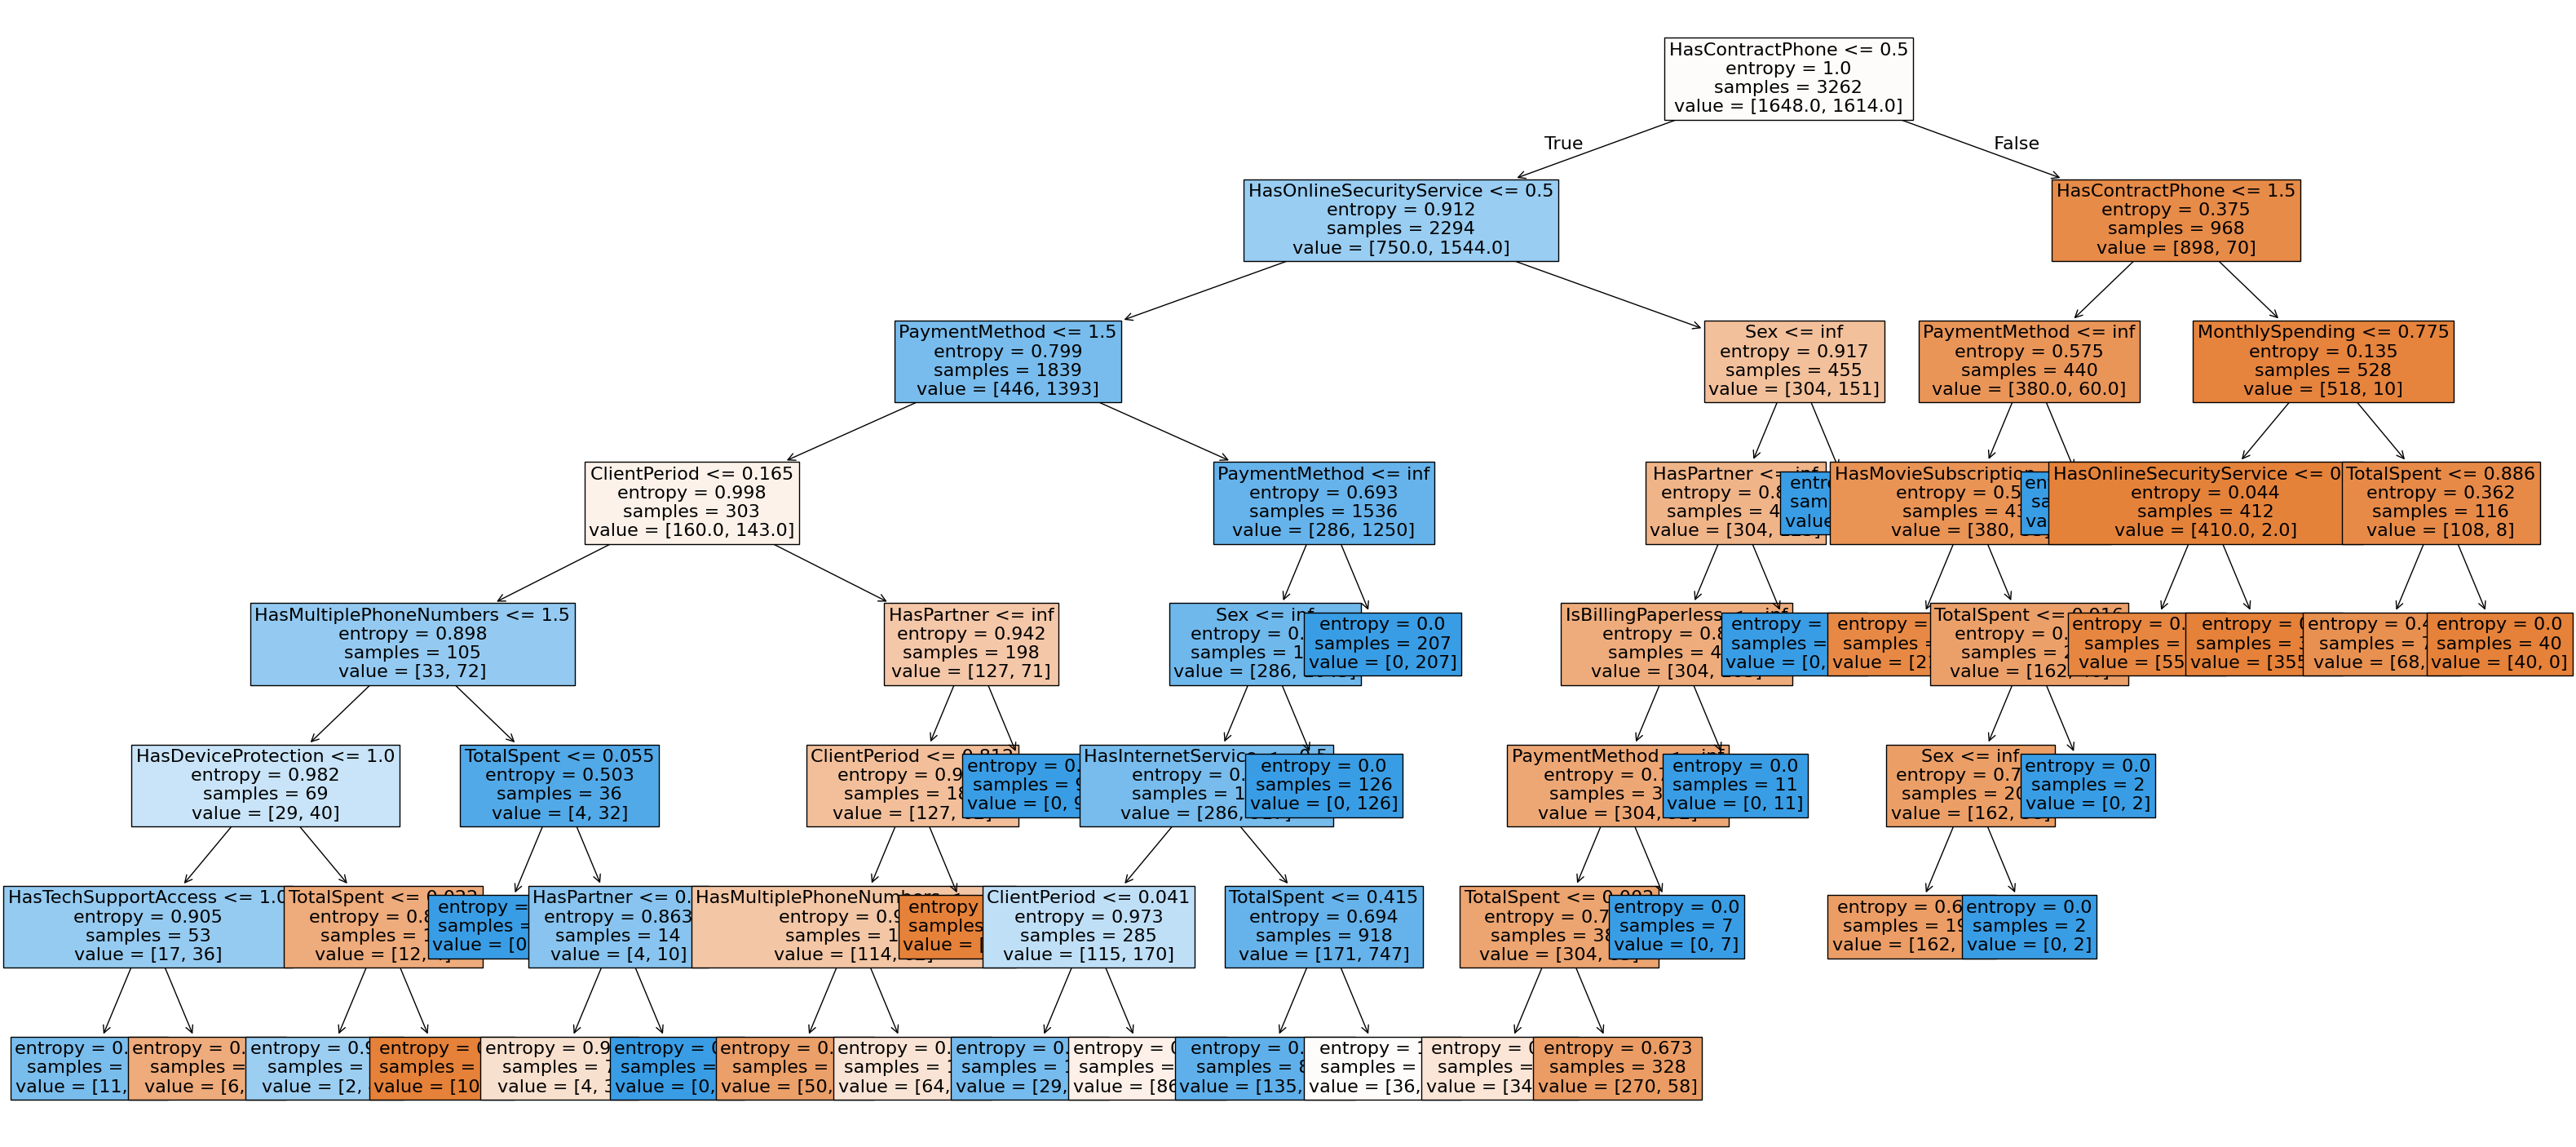

In [157]:
best_parameters_сlass["ccp_alpha"] = grid.best_params_["ccp_alpha"]
model, score_a_c = create_best_model(best_parameters_сlass)

# Важно: убрать max_depth, чтобы он не конфликтовал с ccp_alpha
if "max_depth" in best_parameters_сlass:
    del best_parameters_сlass["max_depth"]

plt.figure(figsize=(40, 18))  # Ширина x Высота в дюймах
tree.plot_tree(model, filled=True, feature_names=list(x_train_class.columns), fontsize=16)
plt.show()


## Регрессия

In [158]:
dtr = DecisionTreeRegressor(max_depth=5)
path = dtr.cost_complexity_pruning_path(x_train_reg, y_train_reg)
params = {
    "ccp_alpha": path.ccp_alphas
}
best_cpp = test_parameters(params, train_acc, test_acc, cross_val_acc, x_train_reg, y_train_reg, x_test_reg, y_test_reg, is_regression=True)

The best model: DecisionTreeRegressor(ccp_alpha=3404583275.7127094)
Accuracy: 0.842


Model: DecisionTreeRegressor(ccp_alpha=3404583275.7127094, criterion='friedman_mse',
                      max_depth=4, max_leaf_nodes=17)
Score: 0.834


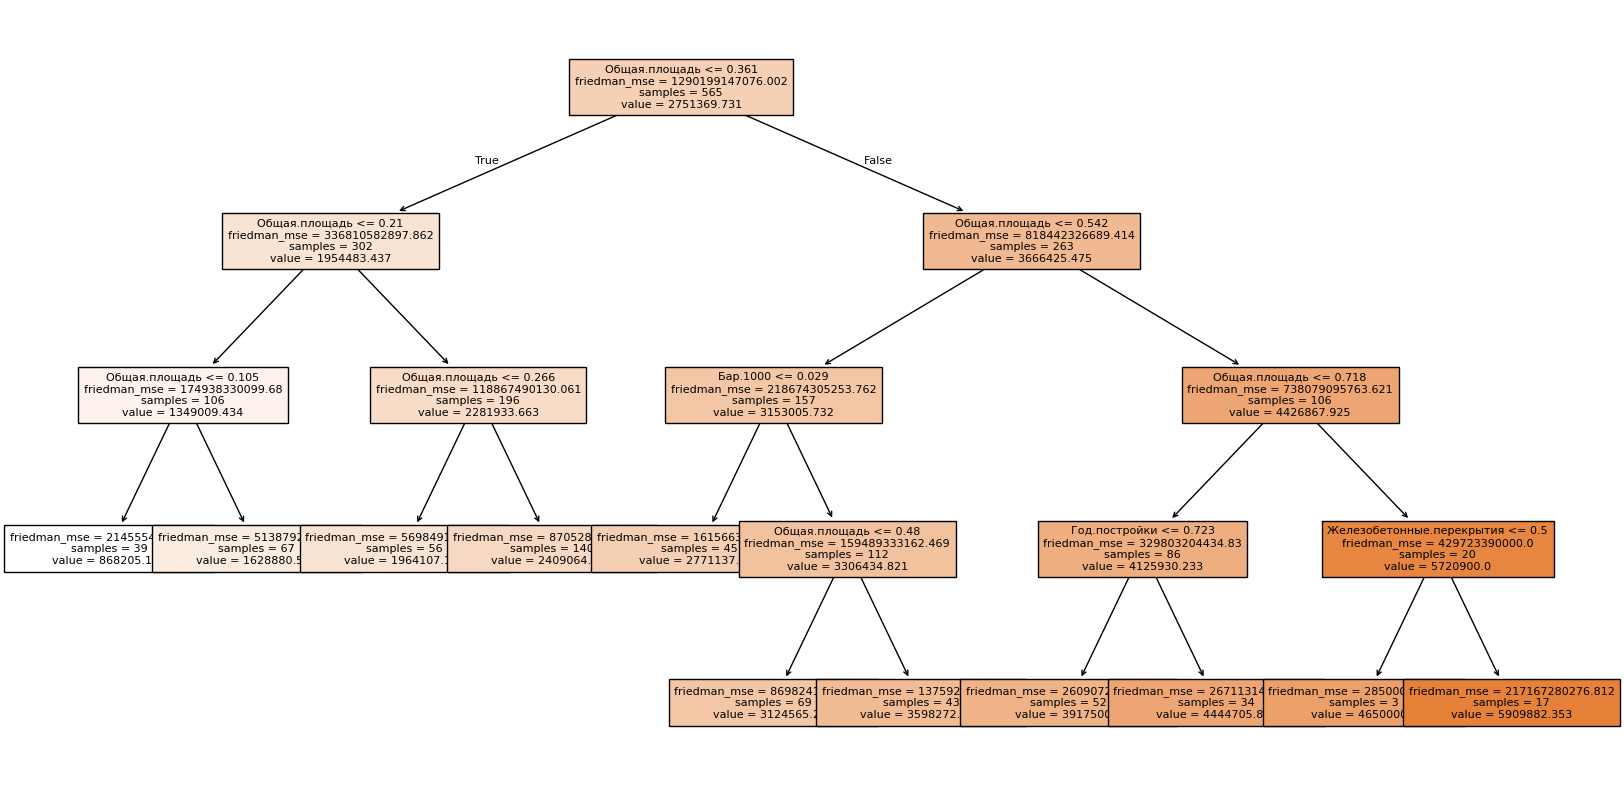

In [159]:
best_parameters_reg["ccp_alpha"] = best_cpp
model, _ = create_best_model(best_parameters_reg, is_regression=True)

plt.figure(figsize=(20, 10))
tree.plot_tree(model, filled=True, feature_names=list(x_test_reg.columns), fontsize=8)
plt.show()

видим, что обрезка дерева приводит к увеличению точности и скора

## Сравнения

#### Данные из 3 работы

In [160]:
class_models = pd.DataFrame(
    {
        "Model name": ["Логистическая регрессия", "Метод Ближайших Соседей", "Наивный Байесовский Классификатор", "Линейный Дискриминантный Анализ",
                         "Квадратичный Дискриминантный Анализ", "Машина Опорных Векторов"],
        "Score": [0.795, 0.925, 0.782, 0.826, 0.827, 0.724],
    }
)


#### Данные из 4 работы

In [161]:
regression_models = pd.DataFrame(
    {
        "Model name": ["Линейная регрессия", "Лассо регрессия", "Гребневая регрессия", "Elastic-Net", "Метод наименьших углов",
                       "Байесовская регрессия", "Обобщённая линейная регрессия", "Взвешенный МНК", "Полиномиальная регрессия",
                       "Непараметрическая регрессия", "Сплайновая регрессия"],
        "R^2": [0.897, 0.898, 0.898, 0.888, 0.897, 0.898, 0.880, 0.878, 0.892, 0.696, 0.880],
    }
)

Добавление новых моделей в таблицы

In [162]:
class_models.loc[len(class_models.index)] = ["Деревья решений", round(class_score, 3)]
print(class_models)


                            Model name  Score
0              Логистическая регрессия  0.795
1              Метод Ближайших Соседей  0.925
2    Наивный Байесовский Классификатор  0.782
3      Линейный Дискриминантный Анализ  0.826
4  Квадратичный Дискриминантный Анализ  0.827
5              Машина Опорных Векторов  0.724
6                      Деревья решений  0.810


In [163]:
regression_models.loc[len(regression_models.index)] = ["Деревья решений", round(regr_score, 3)]
print(regression_models)

                       Model name    R^2
0              Линейная регрессия  0.897
1                 Лассо регрессия  0.898
2             Гребневая регрессия  0.898
3                     Elastic-Net  0.888
4          Метод наименьших углов  0.897
5           Байесовская регрессия  0.898
6   Обобщённая линейная регрессия  0.880
7                  Взвешенный МНК  0.878
8        Полиномиальная регрессия  0.892
9     Непараметрическая регрессия  0.696
10           Сплайновая регрессия  0.880
11                Деревья решений  0.844


In [164]:
def plot_bar_graph(ax, names, scoring, title):
    ax.bar(names, scoring)
    ax.set_title(title)
    ax.tick_params(axis="x", labelrotation=90)  
    ax.set_ylim((0.5, 1))
    for rect, score in zip(ax.patches, scoring):
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 0.01, score, ha="center")
    ax.set_xlabel("Модель", labelpad=15)
    ax.set_ylabel("Score", labelpad=15)

def compare_models():
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(25, 7))
    fig.subplots_adjust(hspace=0.4)
    plot_bar_graph(axs[0], regression_models["Model name"], regression_models["R^2"], "Регрессии")
    plot_bar_graph(axs[1], class_models["Model name"], class_models["Score"], "Классификации")


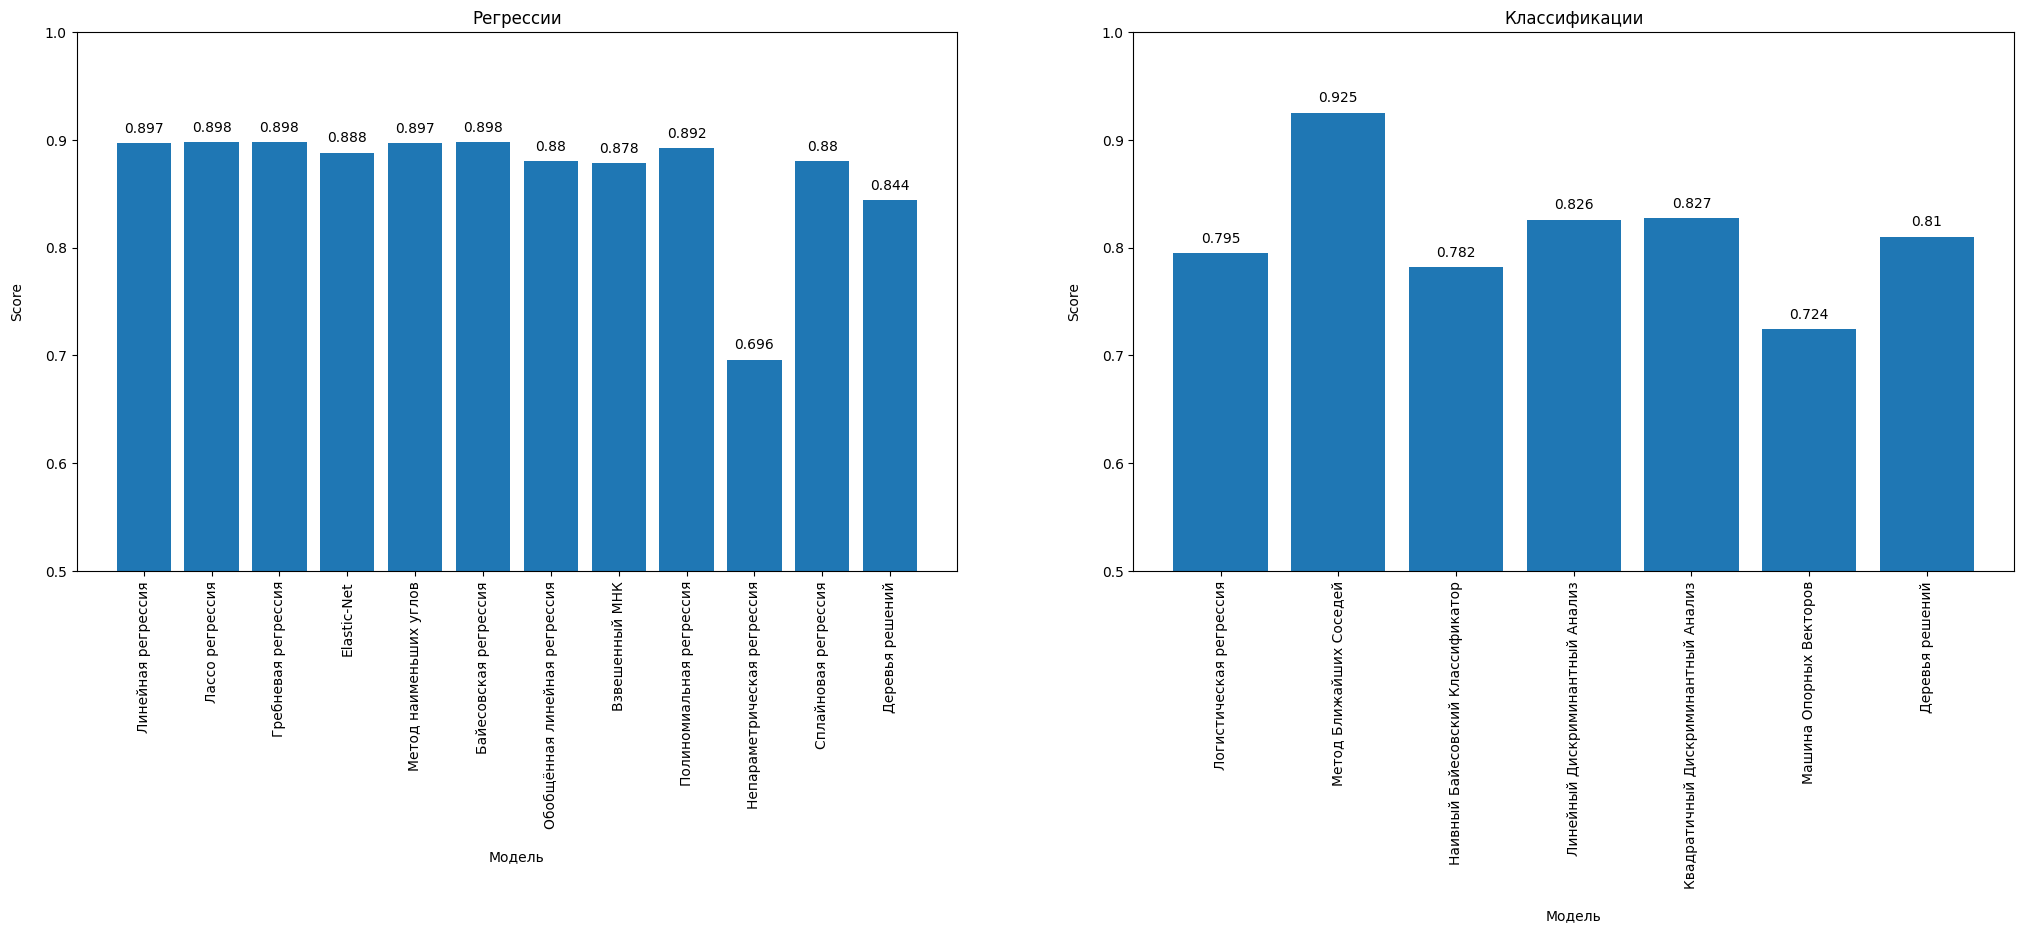

In [165]:
compare_models()